In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
import matplotlib.pyplot as plt


data_dir = '../input/fer2013' #path of dataset
train_dir = os.path.join(data_dir, "train") #we obtain => data_dir/train (train dir under the fer2013 dir)
test_dir = os.path.join(data_dir, "test") #we obtain => data_dir/test  path

first_3_images = {} 

# iterate over each category
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category) #we obtain path for each category (ex = .../train/surprise)
    if os.path.isdir(category_path):  # check if it is a dir or not
        images = sorted(os.listdir(category_path))[:3]  # take the first 3 images
        first_3_images[category] = [os.path.join(category_path, img) for img in images] #path for each img in categories

# print the result
for category, images in first_3_images.items():
    print(f"Category: {category}")
    for img in images:
        print(f"  {img}")

Category: surprise
  ../input/fer2013/train/surprise/Training_10013223.jpg
  ../input/fer2013/train/surprise/Training_1002457.jpg
  ../input/fer2013/train/surprise/Training_10028230.jpg
Category: fear
  ../input/fer2013/train/fear/Training_10018621.jpg
  ../input/fer2013/train/fear/Training_10031494.jpg
  ../input/fer2013/train/fear/Training_10110501.jpg
Category: angry
  ../input/fer2013/train/angry/Training_10118481.jpg
  ../input/fer2013/train/angry/Training_10120469.jpg
  ../input/fer2013/train/angry/Training_10131352.jpg
Category: neutral
  ../input/fer2013/train/neutral/Training_10002154.jpg
  ../input/fer2013/train/neutral/Training_10031781.jpg
  ../input/fer2013/train/neutral/Training_10055498.jpg
Category: sad
  ../input/fer2013/train/sad/Training_10022789.jpg
  ../input/fer2013/train/sad/Training_10031481.jpg
  ../input/fer2013/train/sad/Training_10048646.jpg
Category: disgust
  ../input/fer2013/train/disgust/Training_10371709.jpg
  ../input/fer2013/train/disgust/Training_105

Displaying 3 images for category: surprise


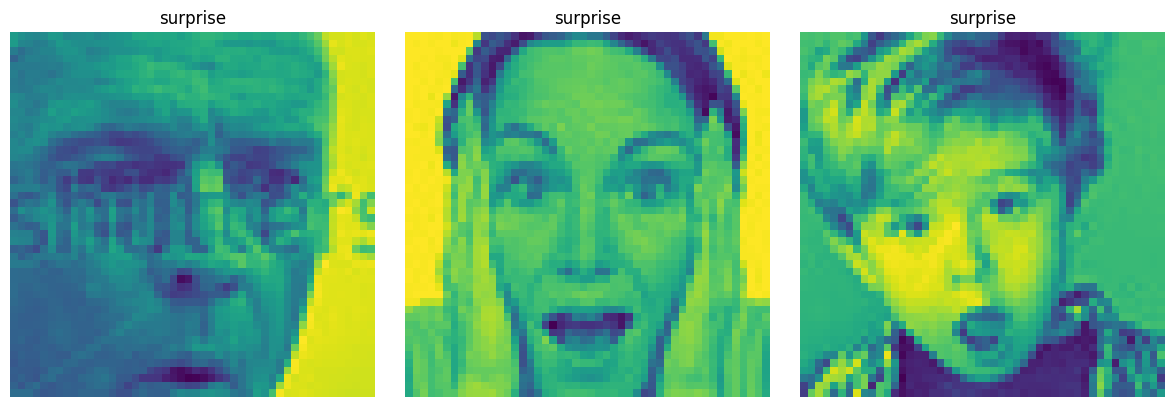

Displaying 3 images for category: fear


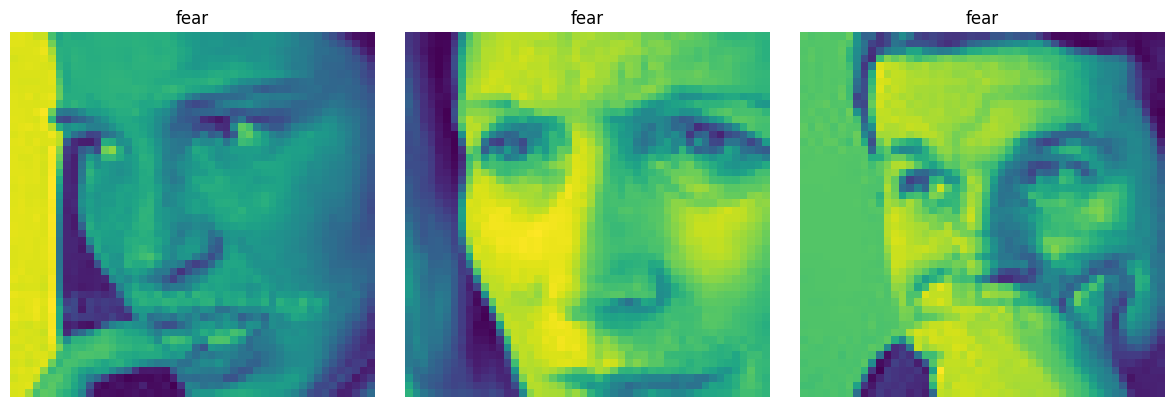

Displaying 3 images for category: angry


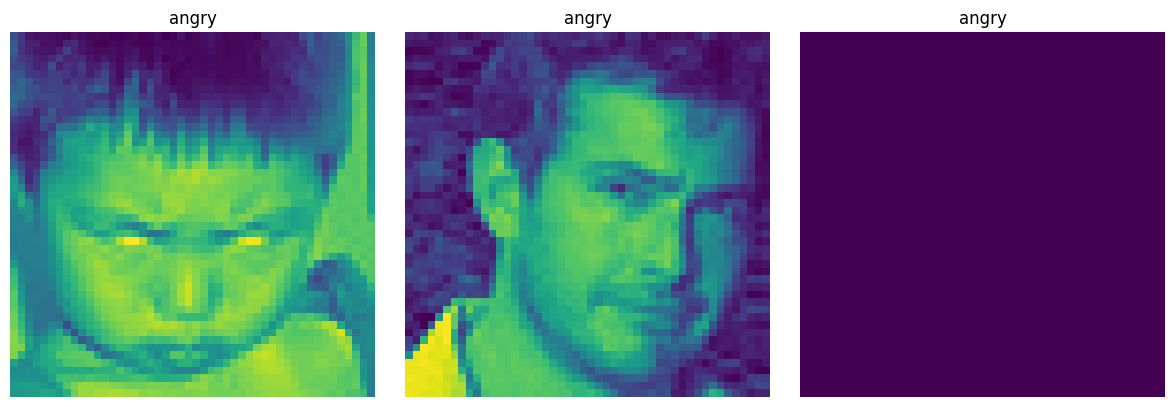

Displaying 3 images for category: neutral


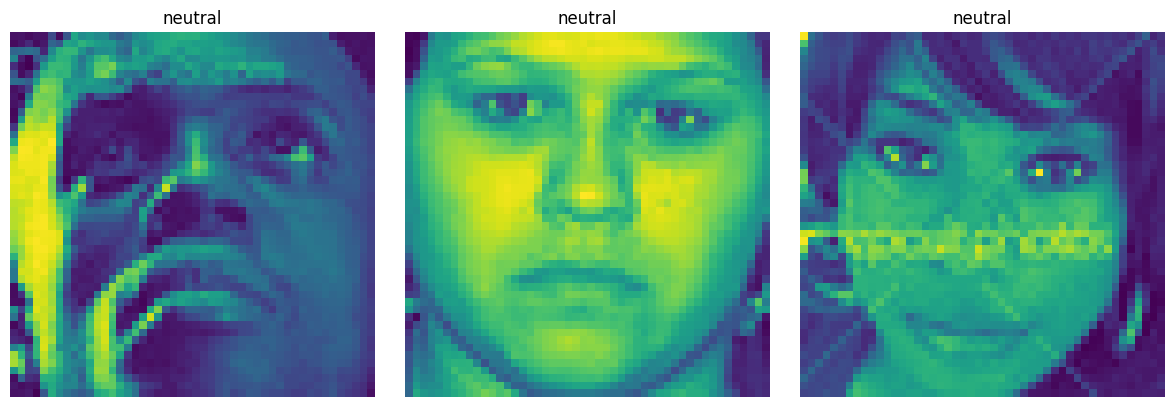

Displaying 3 images for category: sad


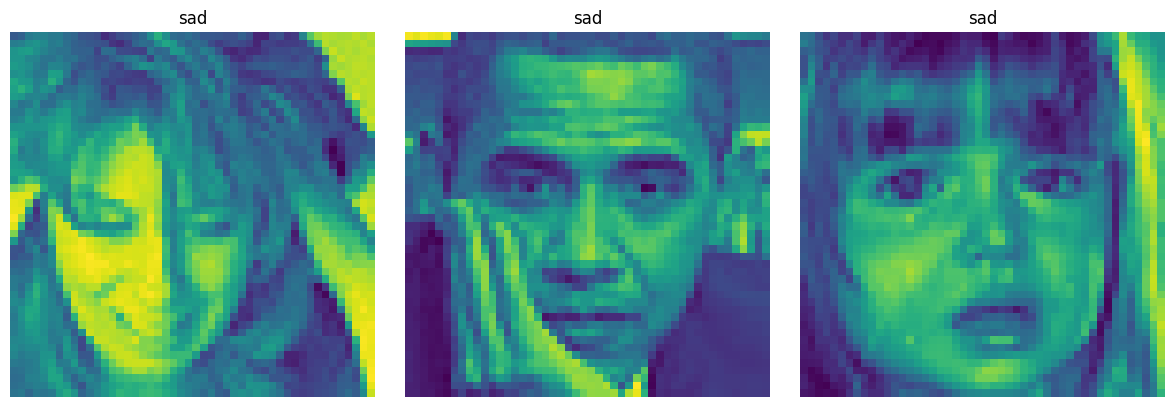

Displaying 3 images for category: disgust


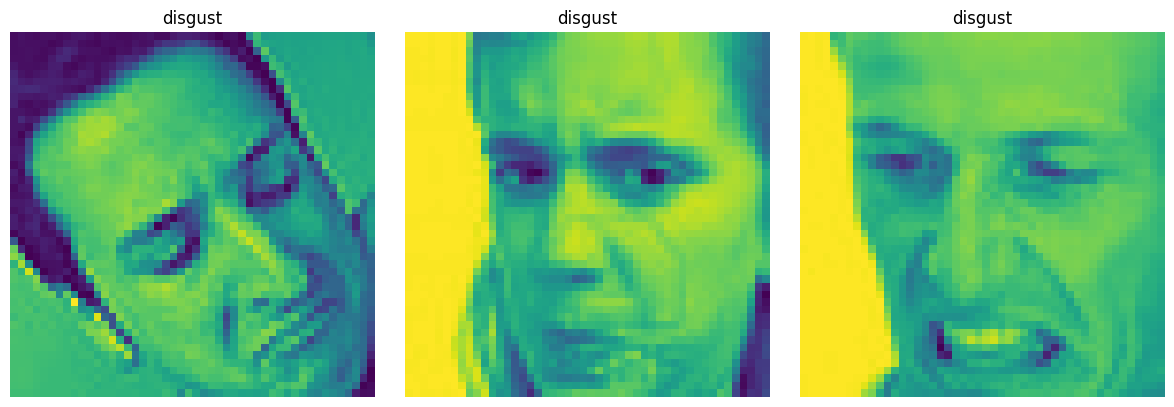

Displaying 3 images for category: happy


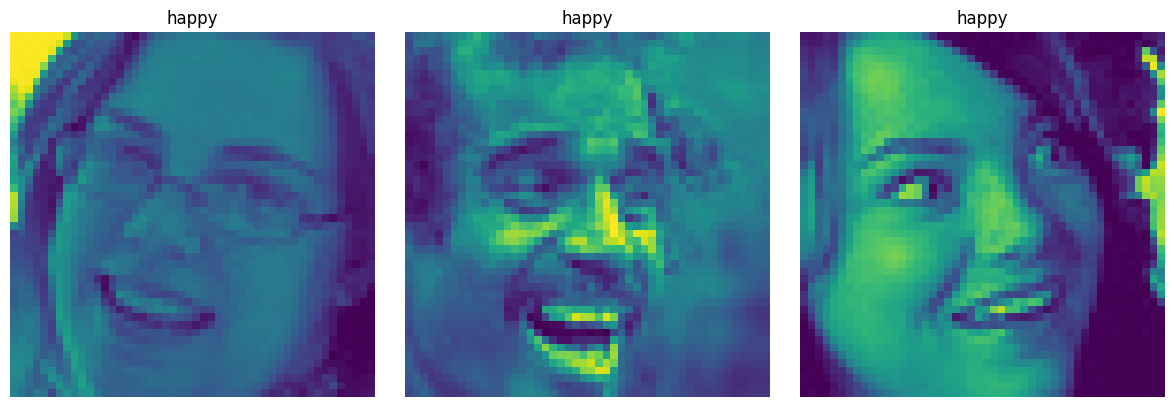

In [3]:
# visualize the first 3 images for each category, side by side
for category, images in first_3_images.items():
    print(f"Displaying 3 images for category: {category}")
    
    # set up a grid for 3 images side by side
    plt.figure(figsize=(12, 4))  # adjust size as needed
    for i, img_path in enumerate(images):
        img = Image.open(img_path)  # open the image
        plt.subplot(1, 3, i + 1)  # create a subplot (1 row, 3 columns)
        plt.imshow(img)  # if you want to display image in grayscale use cmap="gray
        plt.title(category, fontsize=12)  # add title for each image
        plt.axis("off")  # hide axes for clarity
    
    plt.tight_layout()
    plt.show() 

In [4]:
# see how many images we have for each category
categories = os.listdir(train_dir) 
for category in categories:
    category_path = os.path.join(train_dir, category)
    num_images = len(os.listdir(category_path))
    print(f"Category '{category}' has {num_images} images.")

Category 'surprise' has 3171 images.
Category 'fear' has 4097 images.
Category 'angry' has 3995 images.
Category 'neutral' has 4965 images.
Category 'sad' has 4830 images.
Category 'disgust' has 436 images.
Category 'happy' has 7215 images.


In [5]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    categories = os.listdir(folder_path)
    
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    
    for label, category in enumerate(categories):
        category_path = os.path.join(folder_path, category)
        if not os.path.isdir(category_path): # check if it is a dir or not
            print(f"Skipping non-directory: {category_path}")
            continue
        
        for img_name in os.listdir(category_path):
            if not img_name.lower().endswith(valid_extensions): # check if img format is valid or not
                print(f"Skipping unsupported file: {img_name}")
                continue
            
            img_path = os.path.join(category_path, img_name)
            img_path = img_path.replace("\\", "/")  # converting all back slashes to normal slash
            
            try:
                # open the img with pillow (cv2.imread() throws an error so I used pil)
                pil_img = Image.open(img_path).convert('L')  # 'L' is grayscale format
                # resize the images
                pil_img = pil_img.resize((48, 48))
                
                # convert img to np array
                img = np.array(pil_img)
                
                # push img and its label
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder(train_dir)
test_images, test_labels = load_images_from_folder(test_dir)

In [6]:
train_labels[0] #check the result

0

In [7]:
train_images = train_images / 255.0  # normalize to range [0, 1]
test_images = test_images / 255.0

In [8]:
from tensorflow.keras.utils import to_categorical
#one-hot encoding
num_classes = len(categories)
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [9]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split = 0.2 
)
datagen.fit(train_images.reshape(-1, 48, 48, 1))  # images should be 4 dimensionals: (num_samples, height, width, channels)

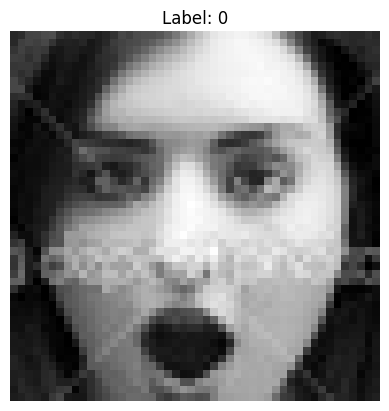

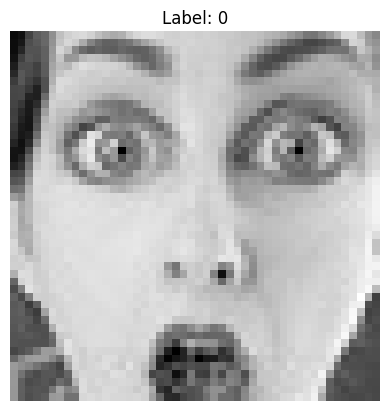

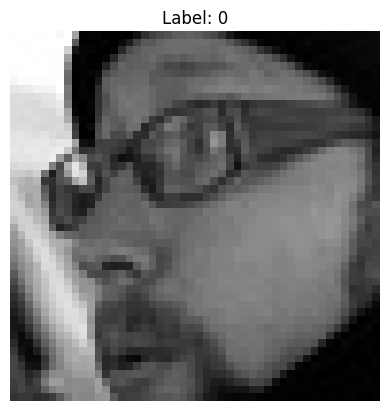

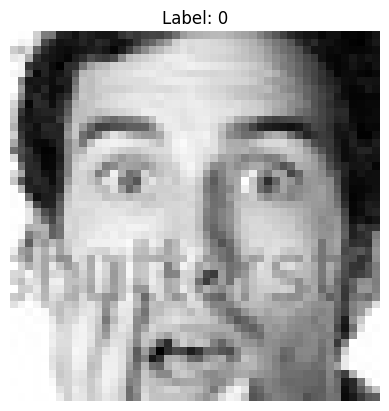

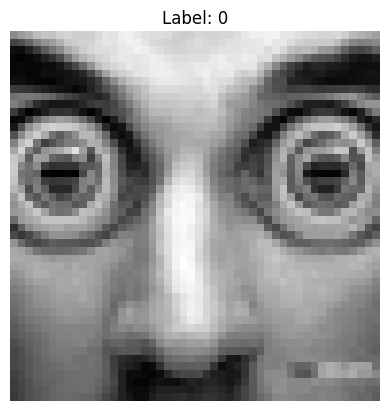

In [10]:
# print the first 5 training images
for i in range(5):
    plt.imshow(train_images[i], cmap="gray")
    plt.title(f"Label: {np.argmax(train_labels[i])}")
    plt.axis("off")
    plt.show()

In [11]:
train_images = train_images.reshape(-1, 48, 48, 1)
test_images = test_images.reshape(-1, 48, 48, 1)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 sınıf için softmax çıkışı
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Modelin özetini yazdır
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,394,183 (5.32 MB)

 Trainable params: 1,391,943 (5.31 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.weights.h5',  # Doğru uzantı
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [18]:
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    validation_data=(test_images, test_labels),
    epochs=50,
    callbacks=[checkpoint_callback, reduce_lr]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734465144.331524      87 service.cc:145] XLA service 0x7e38fc00a4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734465144.331588      87 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  6/449 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.1585 - loss: 3.0451  

I0000 00:00:1734465153.994541      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


445/449 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1703 - loss: 2.8814
Epoch 1: val_accuracy improved from -inf to 0.23447, saving model to model_weights.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.1705 - loss: 2.8795 - val_accuracy: 0.2345 - val_loss: 1.9363 - learning_rate: 1.0000e-04
Epoch 2/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2232 - loss: 2.3934
Epoch 2: val_accuracy improved from 0.23447 to 0.34439, saving model to model_weights.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.2232 - loss: 2.3931 - val_accuracy: 0.3444 - val_loss: 1.7266 - learning_rate: 1.0000e-04
Epoch 3/50
445/449 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2591 - loss: 2.1727
Epoch 3: val_accuracy improved from 0.34439 to 0.37322, saving model to model_weights.weights.h5
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2591 - loss: 2.1724 - val_accuracy: 0.3732 - val_loss: 1.6505 - learning_rate: 1.0000e-04
Epoch 4/50
447/449 ━━

In [19]:
# Modeli test et
results = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Accuracy: {results[1] * 100:.2f}%")

225/225 - 1s - 3ms/step - accuracy: 0.6335 - loss: 0.9819
Test Accuracy: 63.35%


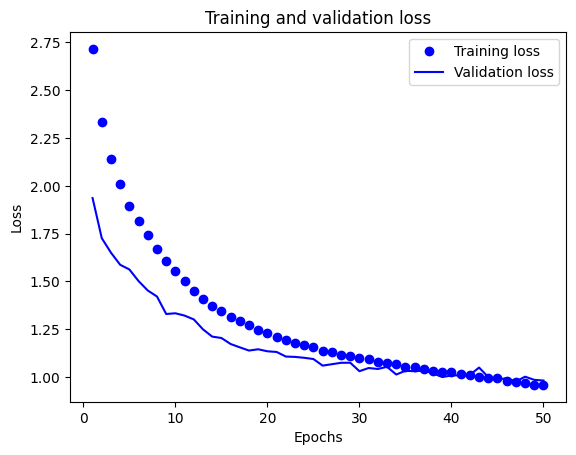

In [20]:
# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

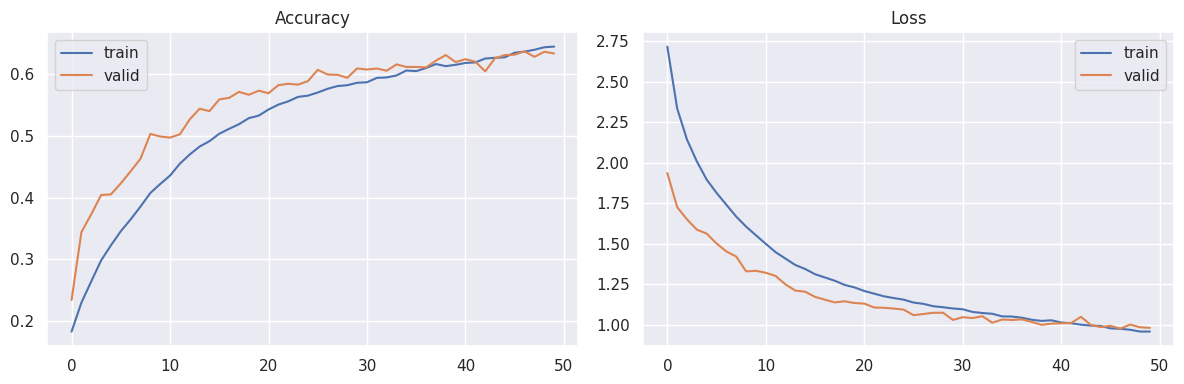

In [68]:
import seaborn as sns
from matplotlib import pyplot
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


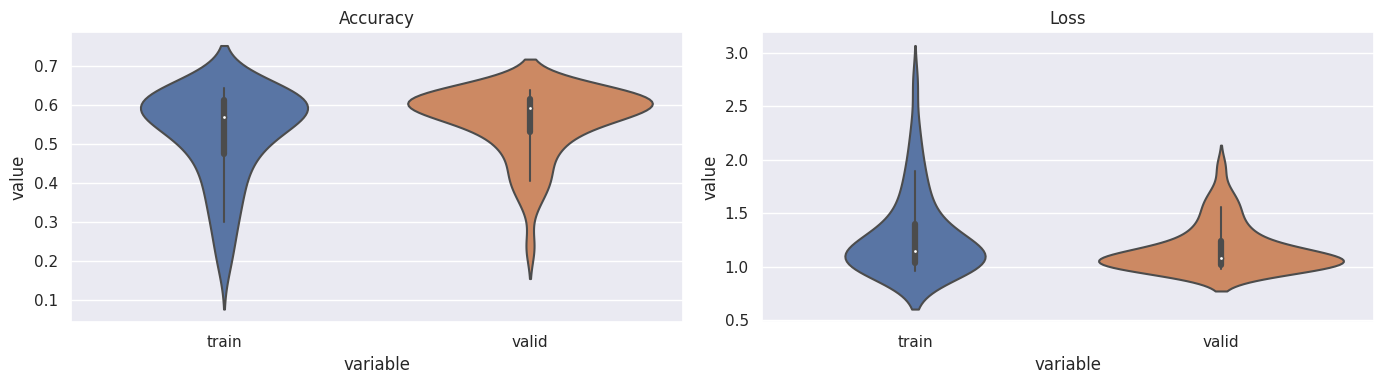

In [69]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

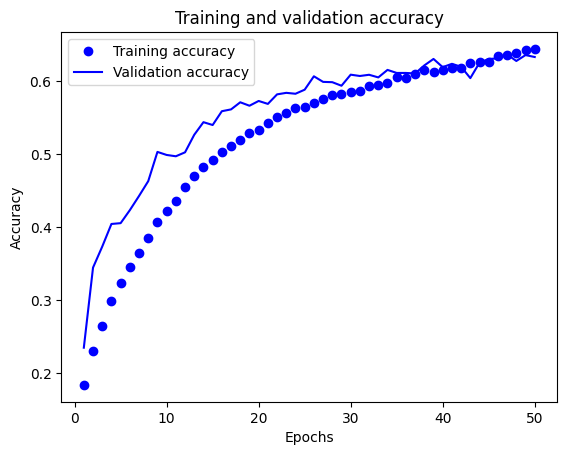

In [21]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

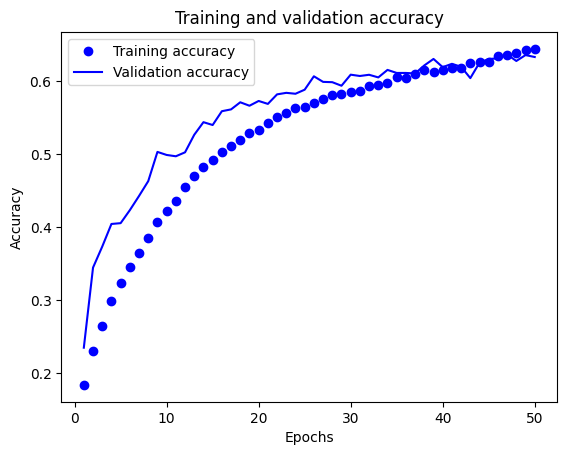

In [22]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

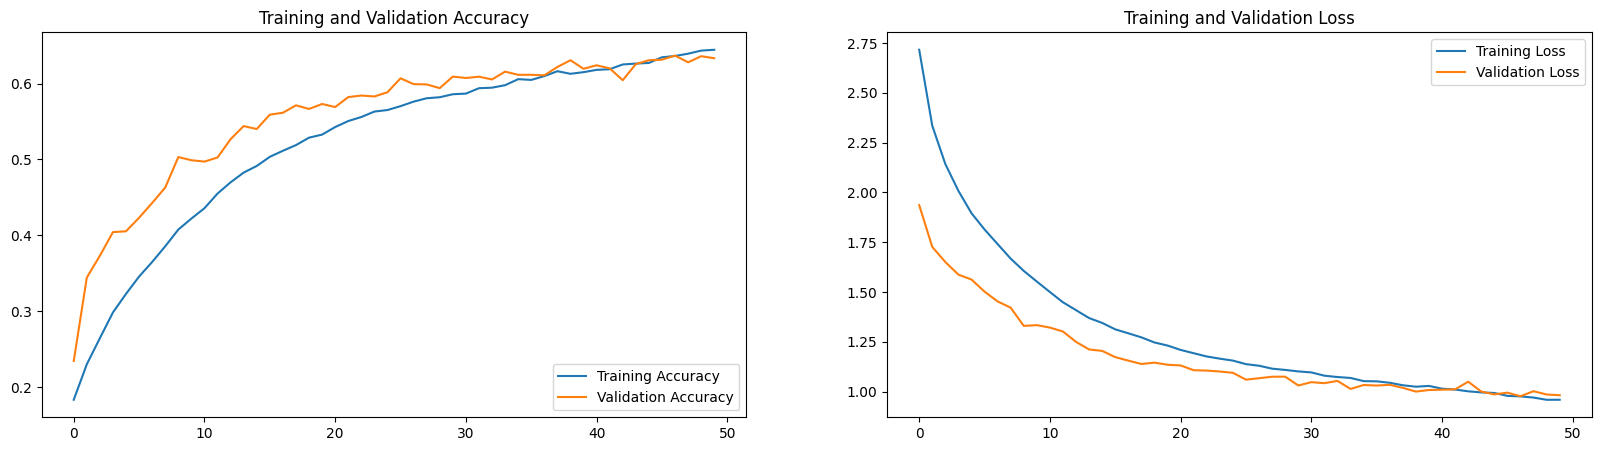

In [27]:
plot_training_history(history)